In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette("viridis")
# sns.set_palette("husl")
plt.style.use('seaborn-v0_8-darkgrid')

In [174]:
print('=' * 100)
print('Data Loading and Exploration')
print('=' * 100)

Data Loading and Exploration


In [175]:
df  = pd.read_csv('databanks_export.csv')

In [176]:
df.shape

(13, 245)

In [177]:
df.head()

,Mnemonic,Parent Mnemonic,Databank,Data Family,Data Source,Units of Measure,First Observation,Frequency,Name of Series,Jan-06,...,Nov-24,Dec-24,Jan-25,Feb-25,Mar-25,Apr-25,May-25,Jun-25,Jul-25,Aug-25
0,GHA_INR_1,GHA_INR_0,INR,Interest rates,Bank of Ghana,"Percent, p.a.",Jan-71,M,Monetary Policy Rate (%),14.5000,...,27.00,27.00,27.0000,27.00,28.00,28.00,28.00,28.00,25.00,25.00
1,GHA_FIN_10,GHA_CPI_02,NAT,Consumer Prices,Ghana Statistical Service,Percent (Base Year=2021),Jan-72,M,Food Inflation,11.6900,...,25.94,27.77,28.3100,28.06,26.52,25.02,22.83,16.31,15.14,14.80
2,GHA_HIN_1,GHA_CPI_02,NAT,Consumer Prices,Ghana Statistical Service,Percent (Base Year=2021),Jan-72,M,Headline Inflation,12.7600,...,23.03,23.82,23.4800,23.13,22.41,21.24,18.38,13.67,12.14,11.48
3,GHA_NFI_20,GHA_CPI_02,NAT,Consumer Prices,Ghana Statistical Service,Percent (Base Year=2021),Jan-72,M,Non-Food Inflation,13.6000,...,20.66,20.32,19.2300,18.77,18.75,17.86,14.43,11.38,9.53,8.65
4,GHA_EXR_4,GHA_EXR_1,EXT,Exchange rates,Bank of Ghana,GHC per USD,Jun-72,M,USD Exchange Rate,0.9083,...,15.27,14.70,15.3001,15.53,15.53,14.15,10.28,10.31,10.50,11.40


In [178]:
df.drop(columns=['Mnemonic', 'Parent Mnemonic', 'Mnemonic', 'Databank',
        'Data Family', 'Data Source', 'Units of Measure', 'First Observation', 'Frequency'], inplace=True)

In [179]:
df.head()

,Name of Series,Jan-06,Feb-06,Mar-06,Apr-06,May-06,Jun-06,Jul-06,Aug-06,Sep-06,...,Nov-24,Dec-24,Jan-25,Feb-25,Mar-25,Apr-25,May-25,Jun-25,Jul-25,Aug-25
0,Monetary Policy Rate (%),14.5000,14.500000,14.500000,14.500000,14.500000,14.50000,14.500000,14.500000,14.500000,...,27.00,27.00,27.0000,27.00,28.00,28.00,28.00,28.00,25.00,25.00
1,Food Inflation,11.6900,10.730000,10.660000,10.550000,11.430000,10.67000,11.840000,10.770000,8.730000,...,25.94,27.77,28.3100,28.06,26.52,25.02,22.83,16.31,15.14,14.80
2,Headline Inflation,12.7600,12.270000,11.280000,11.210000,11.750000,11.39000,12.910000,12.560000,11.670000,...,23.03,23.82,23.4800,23.13,22.41,21.24,18.38,13.67,12.14,11.48
3,Non-Food Inflation,13.6000,13.460000,11.760000,11.720000,11.990000,11.95000,13.730000,13.930000,13.940000,...,20.66,20.32,19.2300,18.77,18.75,17.86,14.43,11.38,9.53,8.65
4,USD Exchange Rate,0.9083,0.909341,0.910591,0.910991,0.912986,0.91615,0.916618,0.919932,0.920386,...,15.27,14.70,15.3001,15.53,15.53,14.15,10.28,10.31,10.50,11.40


In [180]:
df['Name of Series']

0                              Monetary Policy Rate (%)
1                                        Food Inflation
2                                    Headline Inflation
3                                    Non-Food Inflation
4                                     USD Exchange Rate
5     Brent Crude Oil Price (International indicative))
6                Cocoa Price (International indicative)
7                 Gold Price (International indicative)
8                  Interbank Weighted Average (%, p.a.)
9                                    Net Foreign Assets
10                      Net International Reserves, NIR
11                                      Imports (f.o.b)
12                                      Exports (f.o.b)
Name: Name of Series, dtype: object

In [181]:
# Collapse the DataFrame to wide format: months as index, each 'Name of Series' as a column

# Set 'Name of Series' as index and transpose to get the format where columns are series names and rows are months
df_wide = df.set_index('Name of Series').T

# Optionally, reset index to have date as a column
df_wide = df_wide.reset_index().rename(columns={'index': 'Month'})

# Show the first rows to confirm the transformation
df_wide.head()


Name of Series,Month,Monetary Policy Rate (%),Food Inflation,Headline Inflation,Non-Food Inflation,USD Exchange Rate,Brent Crude Oil Price (International indicative)),Cocoa Price (International indicative),Gold Price (International indicative),"Interbank Weighted Average (%, p.a.)",Net Foreign Assets,"Net International Reserves, NIR",Imports (f.o.b),Exports (f.o.b)
0,Jan-06,14.5,11.69,12.76,13.60,0.908300,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1
1,Feb-06,14.5,10.73,12.27,13.46,0.909341,61.1,1482.2,555.6,8.6500,1409.58,1272.3,547.9,287.8
2,Mar-06,14.5,10.66,11.28,11.76,0.910591,63.1,1481.2,557.2,8.3900,1733.84,1597.3,571.8,348.4
3,Apr-06,14.5,10.55,11.21,11.72,0.910991,70.6,1471.6,612.3,8.5725,1762.73,1624.0,515.9,292.3
4,May-06,14.5,11.43,11.75,11.99,0.912986,71.0,1518.3,673.6,9.3975,1727.70,1579.3,523.8,341.6


In [182]:
# # Convert "Month" column to a proper datetime format as month start and rename to "Date"
# df_wide['Date'] = pd.to_datetime(
#     df_wide['Month'], format='%b-%y') + pd.offsets.MonthEnd(0)
# df_wide = df_wide.drop(columns=['Month'])

# # Optionally, move the "Date" column to the front
# cols = ['Date'] + [col for col in df_wide.columns if col != 'Date']
# df_wide = df_wide[cols]

# df_wide.head()

# Convert "Month" column to a proper datetime format as month start and rename to "Date"
df_wide['Date'] = pd.to_datetime(
    df_wide['Month'], format='%b-%y') + pd.offsets.MonthBegin(0)
df_wide = df_wide.drop(columns=['Month'])

# Optionally, move the "Date" column to the front
cols = ['Date'] + [col for col in df_wide.columns if col != 'Date']
df_wide = df_wide[cols]

df_wide.head()

Name of Series,Date,Monetary Policy Rate (%),Food Inflation,Headline Inflation,Non-Food Inflation,USD Exchange Rate,Brent Crude Oil Price (International indicative)),Cocoa Price (International indicative),Gold Price (International indicative),"Interbank Weighted Average (%, p.a.)",Net Foreign Assets,"Net International Reserves, NIR",Imports (f.o.b),Exports (f.o.b)
0,2006-01-01,14.5,11.69,12.76,13.60,0.908300,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1
1,2006-02-01,14.5,10.73,12.27,13.46,0.909341,61.1,1482.2,555.6,8.6500,1409.58,1272.3,547.9,287.8
2,2006-03-01,14.5,10.66,11.28,11.76,0.910591,63.1,1481.2,557.2,8.3900,1733.84,1597.3,571.8,348.4
3,2006-04-01,14.5,10.55,11.21,11.72,0.910991,70.6,1471.6,612.3,8.5725,1762.73,1624.0,515.9,292.3
4,2006-05-01,14.5,11.43,11.75,11.99,0.912986,71.0,1518.3,673.6,9.3975,1727.70,1579.3,523.8,341.6


In [183]:
df_wide.set_index('Date', inplace=True)
# if 'Name of Series' in df_wide.columns:
#     df_wide.drop(columns=['Name of Series'], inplace=True)

In [184]:
df_wide.head()

Name of Series,Monetary Policy Rate (%),Food Inflation,Headline Inflation,Non-Food Inflation,USD Exchange Rate,Brent Crude Oil Price (International indicative)),Cocoa Price (International indicative),Gold Price (International indicative),"Interbank Weighted Average (%, p.a.)",Net Foreign Assets,"Net International Reserves, NIR",Imports (f.o.b),Exports (f.o.b)
Date,,,,,,,,,,,,,
2006-01-01,14.5,11.69,12.76,13.60,0.908300,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1
2006-02-01,14.5,10.73,12.27,13.46,0.909341,61.1,1482.2,555.6,8.6500,1409.58,1272.3,547.9,287.8
2006-03-01,14.5,10.66,11.28,11.76,0.910591,63.1,1481.2,557.2,8.3900,1733.84,1597.3,571.8,348.4
2006-04-01,14.5,10.55,11.21,11.72,0.910991,70.6,1471.6,612.3,8.5725,1762.73,1624.0,515.9,292.3
2006-05-01,14.5,11.43,11.75,11.99,0.912986,71.0,1518.3,673.6,9.3975,1727.70,1579.3,523.8,341.6


In [185]:
df_wide.columns

Index(['Monetary Policy Rate (%)', 'Food Inflation', 'Headline Inflation',
       'Non-Food Inflation', 'USD Exchange Rate',
       'Brent Crude Oil Price (International indicative))',
       'Cocoa Price (International indicative)',
       'Gold Price (International indicative)',
       'Interbank Weighted Average (%, p.a.)', 'Net Foreign Assets',
       'Net International Reserves, NIR', 'Imports (f.o.b)',
       'Exports (f.o.b)'],
      dtype='object', name='Name of Series')

In [186]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236 entries, 2006-01-01 to 2025-08-01
Data columns (total 13 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Monetary Policy Rate (%)                           236 non-null    float64
 1   Food Inflation                                     236 non-null    float64
 2   Headline Inflation                                 236 non-null    float64
 3   Non-Food Inflation                                 236 non-null    float64
 4   USD Exchange Rate                                  236 non-null    float64
 5   Brent Crude Oil Price (International indicative))  236 non-null    float64
 6   Cocoa Price (International indicative)             236 non-null    float64
 7   Gold Price (International indicative)              236 non-null    float64
 8   Interbank Weighted Average (%, p.a.)               236 non-null    floa

In [187]:
# Define a column rename mapping for clearer and shorter names
column_rename_map = {
    'Monetary Policy Rate (%)': 'MPR',
    'Food Inflation': 'FoodInflation',
    'Headline Inflation': 'HeadlineInflation',
    'Non-Food Inflation': 'NonFoodInflation',
    'Brent Crude Oil Price (International indicative))': 'BrentOil',
    'Cocoa Price (International indicative)': 'Cocoa',
    'Gold Price (International indicative)': 'Gold',
    'Interbank Weighted Average (%, p.a.)': 'InterestRate',
    'Net Foreign Assets': 'NetForeignAssets',
    'Net International Reserves, NIR': 'NIR',
    'Imports (f.o.b)': 'Imports',
    'Exports (f.o.b)': 'Exports'
}

df_wide.rename(columns=column_rename_map, inplace=True)

In [188]:
df_wide.drop(columns='USD Exchange Rate', inplace=True)

In [189]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236 entries, 2006-01-01 to 2025-08-01
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MPR                236 non-null    float64
 1   FoodInflation      236 non-null    float64
 2   HeadlineInflation  236 non-null    float64
 3   NonFoodInflation   236 non-null    float64
 4   BrentOil           236 non-null    float64
 5   Cocoa              236 non-null    float64
 6   Gold               236 non-null    float64
 7   InterestRate       236 non-null    float64
 8   NetForeignAssets   236 non-null    float64
 9   NIR                236 non-null    float64
 10  Imports            236 non-null    float64
 11  Exports            236 non-null    float64
dtypes: float64(12)
memory usage: 24.0 KB


In [190]:
col_to_drop = ['FoodInflation', 'NonFoodInflation']
df_wide.drop(columns=col_to_drop, inplace=True)

In [191]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236 entries, 2006-01-01 to 2025-08-01
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MPR                236 non-null    float64
 1   HeadlineInflation  236 non-null    float64
 2   BrentOil           236 non-null    float64
 3   Cocoa              236 non-null    float64
 4   Gold               236 non-null    float64
 5   InterestRate       236 non-null    float64
 6   NetForeignAssets   236 non-null    float64
 7   NIR                236 non-null    float64
 8   Imports            236 non-null    float64
 9   Exports            236 non-null    float64
dtypes: float64(10)
memory usage: 20.3 KB


In [192]:
# Convert monthly data in df_wide to daily data
daily_dataset = df_wide.resample('D').ffill()

# Display the first few rows of the daily dataset
daily_dataset.head()

Name of Series,MPR,HeadlineInflation,BrentOil,Cocoa,Gold,InterestRate,NetForeignAssets,NIR,Imports,Exports
Date,,,,,,,,,,
2006-01-01,14.5,12.76,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1
2006-01-02,14.5,12.76,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1
2006-01-03,14.5,12.76,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1
2006-01-04,14.5,12.76,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1
2006-01-05,14.5,12.76,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1


In [193]:
daily_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7153 entries, 2006-01-01 to 2025-08-01
Freq: D
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MPR                7153 non-null   float64
 1   HeadlineInflation  7153 non-null   float64
 2   BrentOil           7153 non-null   float64
 3   Cocoa              7153 non-null   float64
 4   Gold               7153 non-null   float64
 5   InterestRate       7153 non-null   float64
 6   NetForeignAssets   7153 non-null   float64
 7   NIR                7153 non-null   float64
 8   Imports            7153 non-null   float64
 9   Exports            7153 non-null   float64
dtypes: float64(10)
memory usage: 614.7 KB


In [290]:
daily_dataset.head()

Name of Series,MPR,HeadlineInflation,BrentOil,Cocoa,Gold,InterestRate,NetForeignAssets,NIR,Imports,Exports
Date,,,,,,,,,,
2006-01-01,14.5,12.76,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1
2006-01-02,14.5,12.76,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1
2006-01-03,14.5,12.76,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1
2006-01-04,14.5,12.76,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1
2006-01-05,14.5,12.76,63.9,1518.3,550.8,10.3425,1422.81,1286.4,490.8,330.1


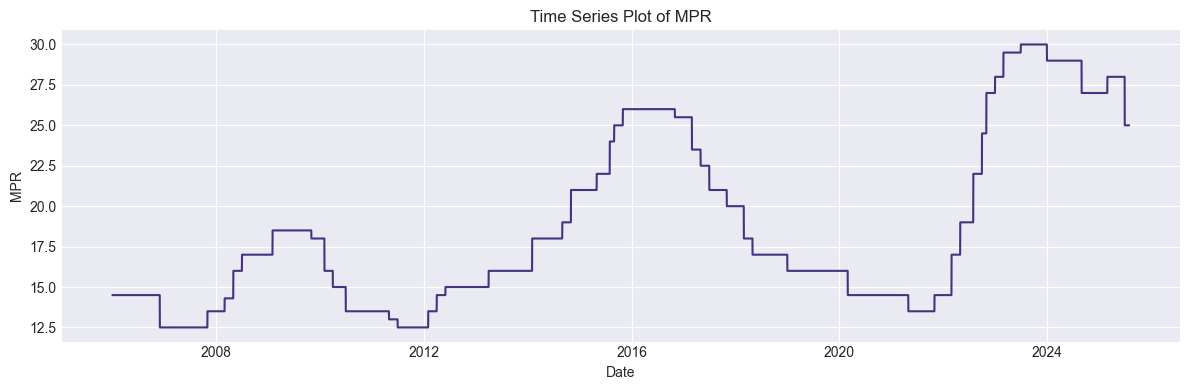

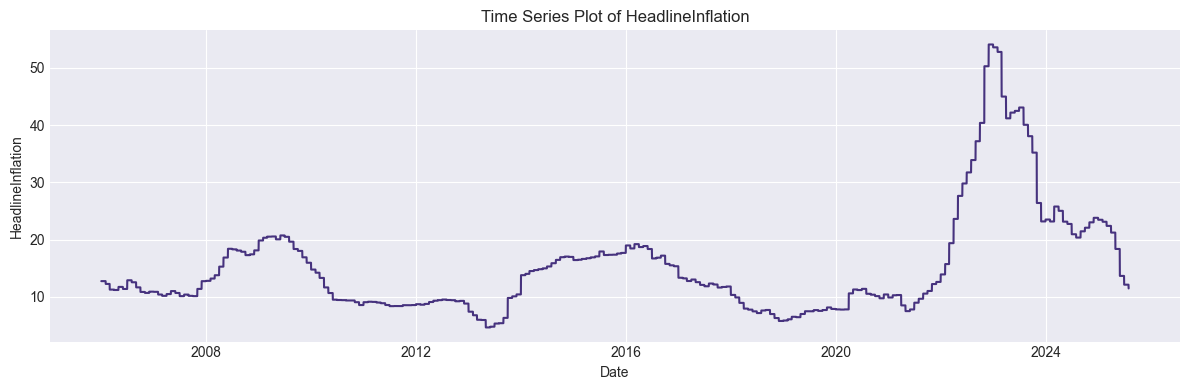

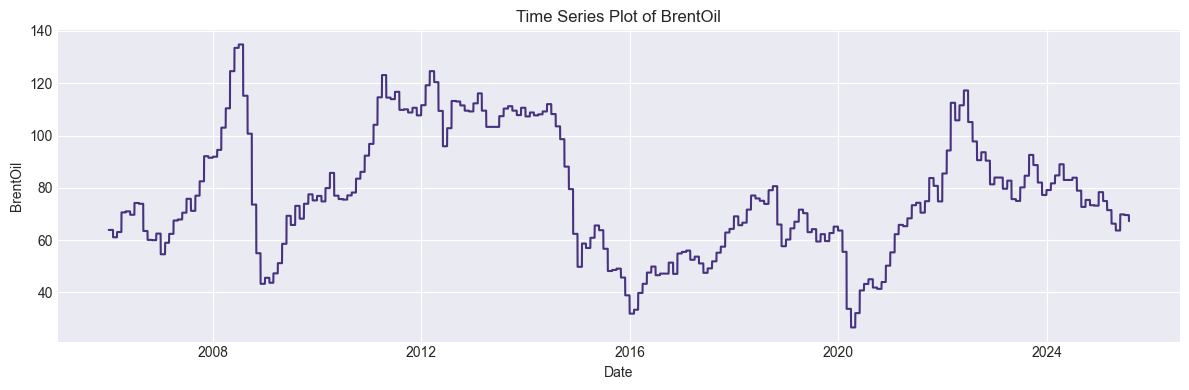

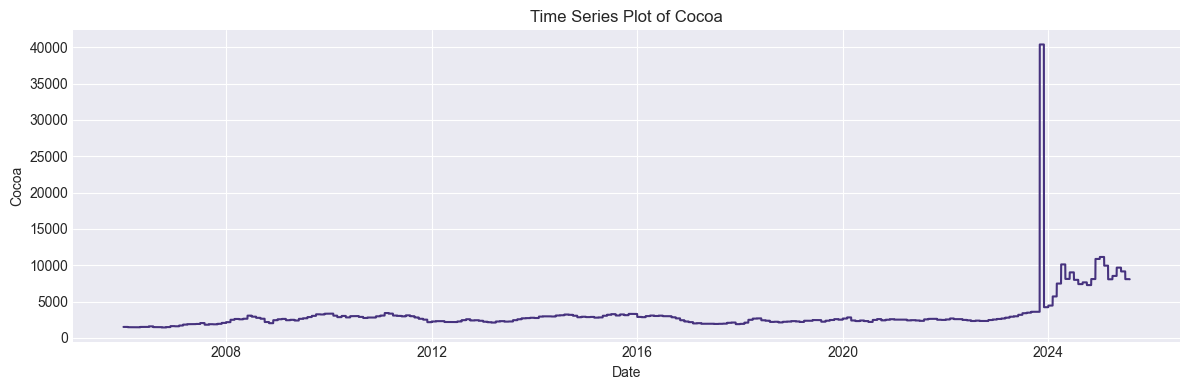

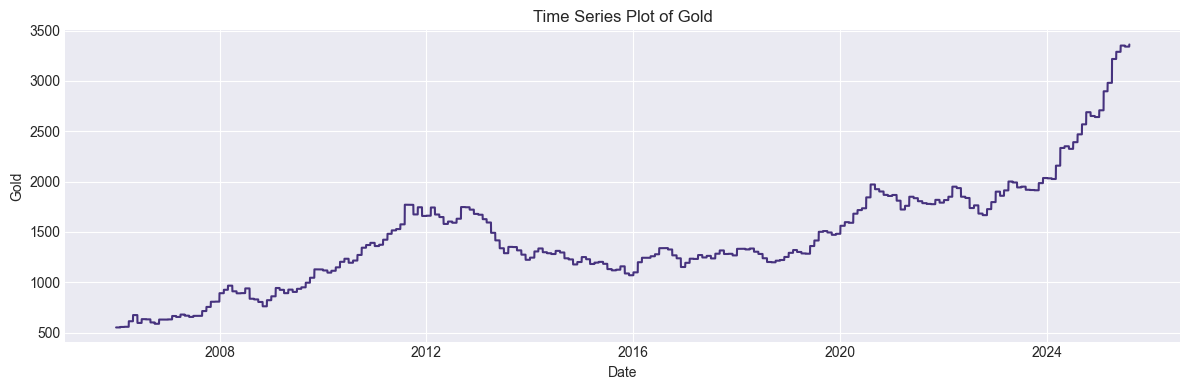

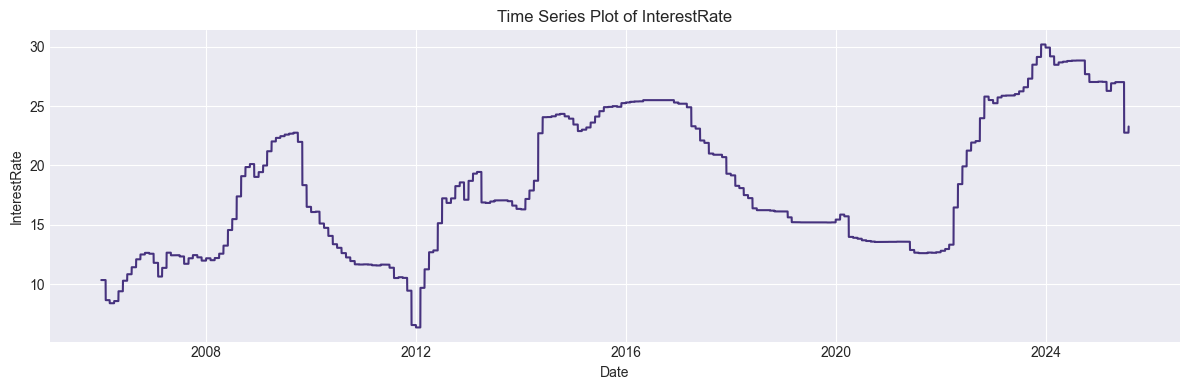

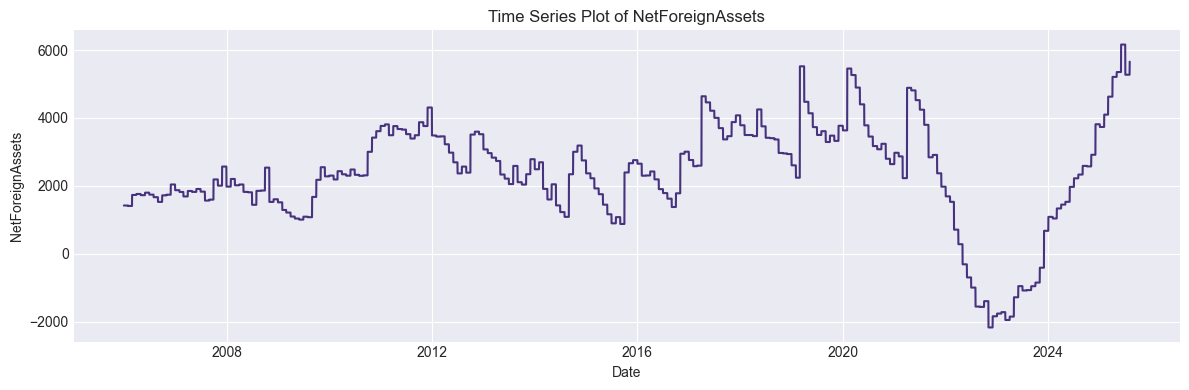

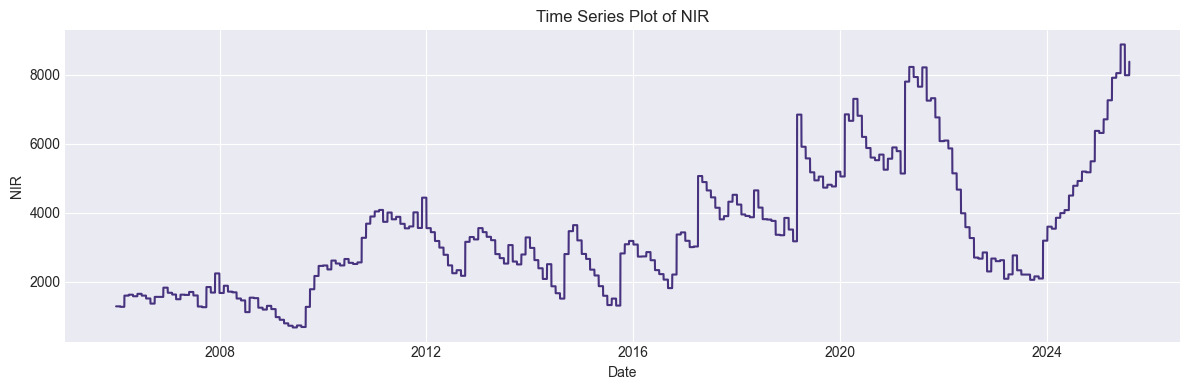

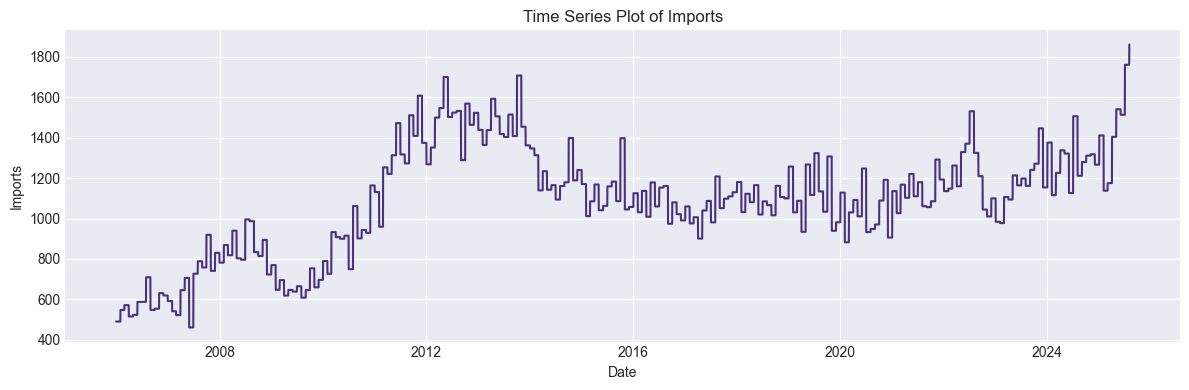

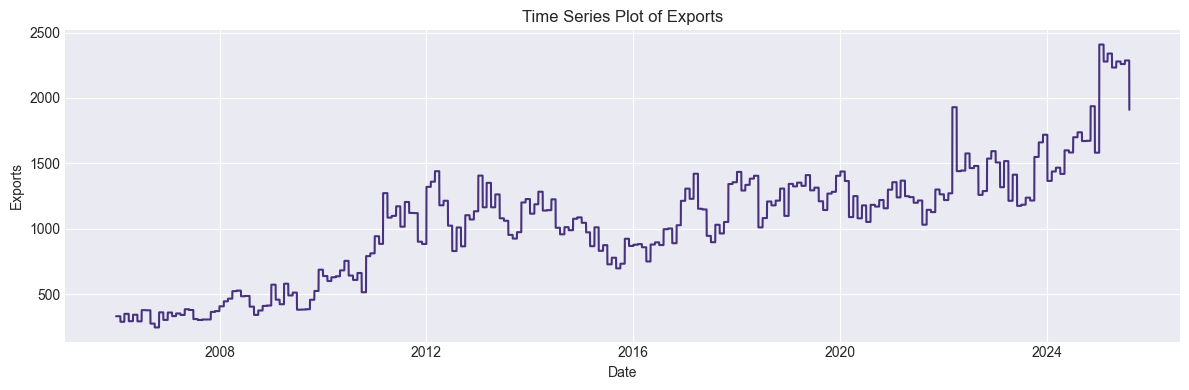

In [569]:
import matplotlib.pyplot as plt

# Generate a plot for each column in the daily_dataset (excluding the index)
for col in daily_dataset.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(daily_dataset.index, daily_dataset[col])
    plt.title(f'Time Series Plot of {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


In [291]:
daily_dataset.to_csv('daily_dataset.csv')

In [195]:
# import yfinance as yf

# # Get USD/GHS currency data from Yahoo Finance (yfinance) for the period 2006-01-01 to 2024-01-01 to include all of 2006
# usdghs = yf.download('USDGHS=X', start='2006-01-01', end='2024-01-01')
# # Reset index to get Date as a column (optional; up to your usage needs)
# usdghs.reset_index(inplace=True)


### TODO:
- Import Datasets For Prediction Model:
    - Macroeconomic
        - GDP (Ghana & US) (Percentage)
        - Interest rates (Gh & US) (Percentage)
        - Inflation rates (Gh & US) (Percentage)
        - Monetary Policy Rate (%)
    - Daily FX rates
    - Commodity Prices ($)
        - Cocoa
        - Oil
        - Gold
- Filter Dates on datasets, Start from the year 2000-2023

### Ghana FX Rates

In [292]:
exchange_rates = pd.read_csv('datasets/exchange rates.csv')
exchange_rates.drop(columns=['Currency', 'Currency Pair'], inplace=True)

In [293]:
exchange_rates.head()

,Date,Buying,Selling,Mid Rate
0,31-Dec-24,14.6927,14.7074,14.7
1,30-Dec-24,14.7026,14.7174,14.71
2,27-Dec-24,14.6927,14.7074,14.7
3,24-Dec-24,14.6427,14.6573,14.65
4,23-Dec-24,14.6427,14.6573,14.65


In [294]:
exchange_rates.tail()

,Date,Buying,Selling,Mid Rate
4212,08-Jan-08,0.9576,0.98,0.9688
4213,07-Jan-08,0.9551,0.9809,0.968
4214,04-Jan-08,0.9543,0.9798,0.9671
4215,03-Jan-08,0.9545,0.9799,0.9672
4216,02-Jan-08,0.9545,0.9799,0.9672


In [295]:
# Convert 'Date' to datetime
exchange_rates['Date'] = pd.to_datetime(exchange_rates['Date'], dayfirst=True, errors='coerce')

# # Filter between Jan 2000 and Dec 2023 (inclusive)
# start_date = pd.Timestamp('2006-01-01')
# end_date = pd.Timestamp('2023-12-31')
# exchange_rates_filtered = exchange_rates[
#     (exchange_rates['Date'] >= start_date) & (exchange_rates['Date'] <= end_date)
# ].copy()

exchange_rates.tail()

,Date,Buying,Selling,Mid Rate
4212,2008-01-08,0.9576,0.98,0.9688
4213,2008-01-07,0.9551,0.9809,0.968
4214,2008-01-04,0.9543,0.9798,0.9671
4215,2008-01-03,0.9545,0.9799,0.9672
4216,2008-01-02,0.9545,0.9799,0.9672


In [296]:
exchange_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4217 non-null   datetime64[ns]
 1   Buying    4217 non-null   float64       
 2   Selling   4217 non-null   object        
 3   Mid Rate  4217 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 131.9+ KB


<Axes: >

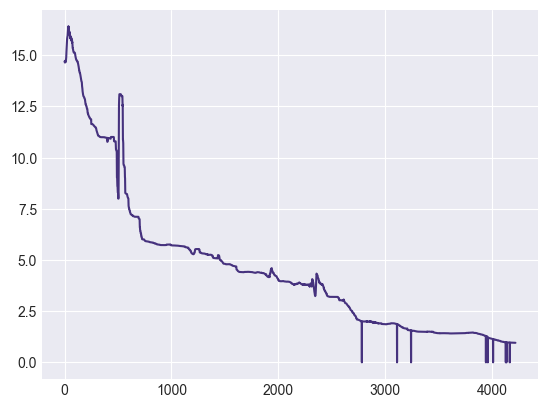

In [571]:
exchange_rates['Buying'].plot()

In [297]:
exchange_rates.to_csv('datasets/cleaned/exchange rates.csv', index=False)

#### US Data

In [393]:
us_gdp = pd.read_csv('datasets/us/gdp.csv')

In [394]:
us_gdp.head()

,Date,US_GDP
0,01/01/2008,16843.003
1,01/04/2008,16943.291
2,01/07/2008,16854.295
3,01/10/2008,16485.350
4,01/01/2009,16298.262


In [395]:
us_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    68 non-null     object 
 1   US_GDP  68 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In [396]:
us_gdp.head()

,Date,US_GDP
0,01/01/2008,16843.003
1,01/04/2008,16943.291
2,01/07/2008,16854.295
3,01/10/2008,16485.350
4,01/01/2009,16298.262


In [399]:
# Fill the missing daily data for the last incomplete quarter (2024Q4) if data ends at 2024-10-01

# Parse quarter start dates from the 'Date' column and upsample
us_gdp['Date'] = pd.to_datetime(us_gdp['Date'], dayfirst=True, errors='coerce')
us_gdp = us_gdp.sort_values('Date').reset_index(drop=True)

# Get the last available quarterly entry to check if any quarter is incomplete
last_quarter_start = us_gdp['Date'].iloc[-1]
last_gdp_value = us_gdp['US_GDP'].iloc[-1]

# Check if last entry is the start of a quarter (e.g., Jan 1, Apr 1, Jul 1, Oct 1)
if last_quarter_start.month in [1, 4, 7, 10]:
    # Compute expected last day of that quarter
    last_quarter_end = (last_quarter_start + pd.offsets.QuarterEnd(0)).normalize()
    # If data does not extend to the end of quarter, extend it
    if us_gdp['Date'].max() < last_quarter_end:
        # Append missing entry for the last quarter, if not already present
        if not (us_gdp['Date'] == last_quarter_end).any():
            new_row = pd.DataFrame({'Date': [last_quarter_end], 'US_GDP': [last_gdp_value]})
            us_gdp = pd.concat([us_gdp, new_row], ignore_index=True)
        us_gdp = us_gdp.sort_values('Date').reset_index(drop=True)

# Now upsample to daily frequency and forward fill
us_gdp = us_gdp.set_index('Date').asfreq('D').ffill().reset_index()
us_gdp.head()

,Date,US_GDP
0,2008-01-01,16843.003
1,2008-01-02,16843.003
2,2008-01-03,16843.003
3,2008-01-04,16843.003
4,2008-01-05,16843.003


In [400]:
us_gdp.tail()

,Date,US_GDP
6205,2024-12-27,23542.349
6206,2024-12-28,23542.349
6207,2024-12-29,23542.349
6208,2024-12-30,23542.349
6209,2024-12-31,23542.349


In [404]:
# # Convert quarterly data in us_gdp to daily data
# daily_us_gdp = []

# for _, row in us_gdp.iterrows():
#     quarter_start = pd.Timestamp(row['Date'])  # Start of the quarter
#     gdp_value = row['US_GDP']  # GDP value for the quarter

#     # Determine the end of the quarter based on the start date
#     if quarter_start.month in [1, 4, 7, 10]:
#         quarter_end = quarter_start + pd.offsets.QuarterEnd(0)
#     else:
#         continue  # Skip invalid dates

#     # Generate daily dates for the quarter and assign the GDP value
#     daily_dates = pd.date_range(start=quarter_start, end=quarter_end, freq='D')
#     for date in daily_dates:
#         daily_us_gdp.append({'Date': date, 'US_GDP': gdp_value})

# # Create a DataFrame for the daily data
# daily_us_gdp_df = pd.DataFrame(daily_us_gdp)

# # Display the first few rows of the daily dataset
# daily_us_gdp_df.head()

In [406]:
us_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6210 entries, 0 to 6209
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6210 non-null   datetime64[ns]
 1   US_GDP  6210 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 97.2 KB


In [408]:
us_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6210 entries, 0 to 6209
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6210 non-null   datetime64[ns]
 1   US_GDP  6210 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 97.2 KB


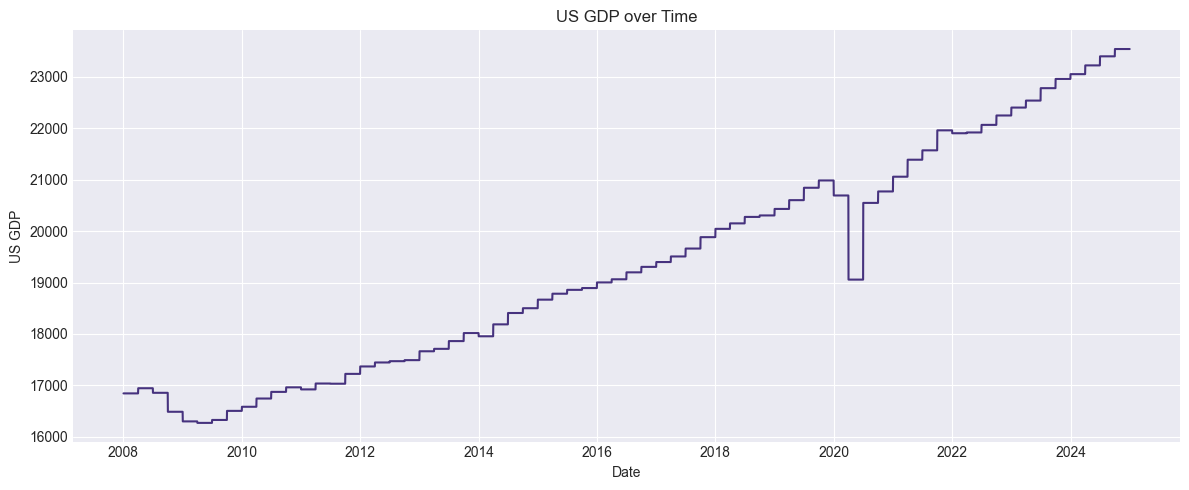

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(us_gdp['Date'], us_gdp['US_GDP'])
plt.xlabel('Date')
plt.ylabel('US GDP')
plt.title('US GDP over Time')
plt.tight_layout()
plt.show()


In [409]:
us_gdp.to_csv('datasets/cleaned/us_gdp_daily.csv', index=False)

### US Inflation

In [528]:
us_inflation = pd.read_csv('datasets/us/inflation PCEPILFE.csv')

In [529]:
us_inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               204 non-null    object 
 1   US_Inflation_Rate  204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


In [442]:
us_inflation.head()

,Date,US_Inflation_Rate
0,01/01/2008,87.093
1,01/02/2008,87.178
2,01/03/2008,87.349
3,01/04/2008,87.400
4,01/05/2008,87.559


In [443]:
us_inflation.tail()

,Date,US_Inflation_Rate
199,01/08/2024,122.926
200,01/09/2024,123.234
201,01/10/2024,123.595
202,01/11/2024,123.716
203,01/12/2024,123.980


In [530]:
us_inflation['Date'] = pd.to_datetime(us_inflation['Date'], dayfirst=True)
us_inflation.set_index('Date', inplace=True)

In [531]:
us_inflation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2008-01-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   US_Inflation_Rate  204 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [532]:
# Ensure last day is included if missing due to upsample edge
last_date = pd.to_datetime('2024-12-31')
if us_inflation.index.max() < last_date:
    # Extend the index to the last day of 2024
    new_idx = pd.date_range(start=us_inflation.index.min(), end=last_date, freq='D')
    us_inflation = us_inflation.reindex(new_idx, method='ffill')
us_inflation_daily = us_inflation

In [533]:
us_inflation_daily.head()

,US_Inflation_Rate
2008-01-01,87.093
2008-01-02,87.093
2008-01-03,87.093
2008-01-04,87.093
2008-01-05,87.093


In [534]:
us_inflation_daily.tail()

,US_Inflation_Rate
2024-12-27,123.98
2024-12-28,123.98
2024-12-29,123.98
2024-12-30,123.98
2024-12-31,123.98


In [535]:
us_inflation_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6210 entries, 2008-01-01 to 2024-12-31
Freq: D
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   US_Inflation_Rate  6210 non-null   float64
dtypes: float64(1)
memory usage: 97.0 KB


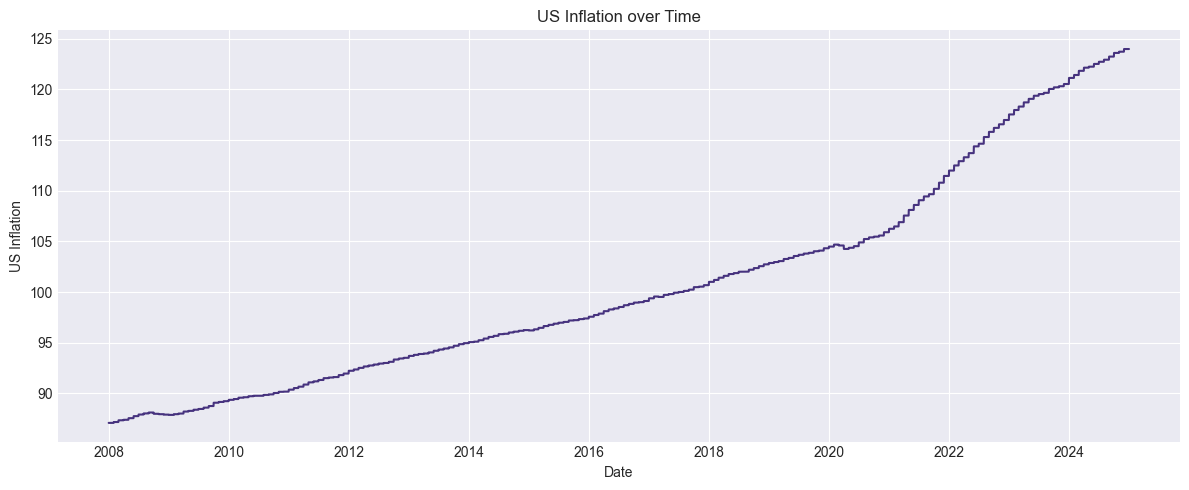

In [577]:
plt.figure(figsize=(12, 5))
plt.plot(us_inflation.index, us_inflation['US_Inflation_Rate'])
plt.xlabel('Date')
plt.ylabel('US Inflation')
plt.title('US Inflation over Time')
plt.tight_layout()
plt.show()

In [536]:
us_inflation_daily.to_csv('datasets/cleaned/us_inflation_daily.csv', index=True)

### US Interest Rate Data

In [463]:
us_interest_rate = pd.read_csv('datasets/us/interest rates.csv')

In [464]:
us_interest_rate.head()

,Date,US_Interest_Rate
0,01/01/2008,3.06
1,02/01/2008,4.11
2,03/01/2008,4.25
3,04/01/2008,4.18
4,05/01/2008,4.18


In [465]:
us_interest_rate.tail()

,Date,US_Interest_Rate
6205,27/12/2024,4.33
6206,28/12/2024,4.33
6207,29/12/2024,4.33
6208,30/12/2024,4.33
6209,31/12/2024,4.33


In [466]:
us_interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6210 entries, 0 to 6209
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              6210 non-null   object 
 1   US_Interest_Rate  6210 non-null   float64
dtypes: float64(1), object(1)
memory usage: 97.2+ KB


In [467]:
us_interest_rate.shape

(6210, 2)

In [468]:
us_interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6210 entries, 0 to 6209
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              6210 non-null   object 
 1   US_Interest_Rate  6210 non-null   float64
dtypes: float64(1), object(1)
memory usage: 97.2+ KB


In [469]:
us_interest_rate['Date'] = pd.to_datetime(us_interest_rate['Date'], format='mixed', dayfirst=True, errors='coerce')
us_interest_rate.set_index('Date', inplace=True)

In [ ]:
# us_interest_rate['Date'] = pd.to_datetime(us_interest_rate['Date'], errors='coerce')

In [470]:
us_interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6210 entries, 2008-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   US_Interest_Rate  6210 non-null   float64
dtypes: float64(1)
memory usage: 97.0 KB


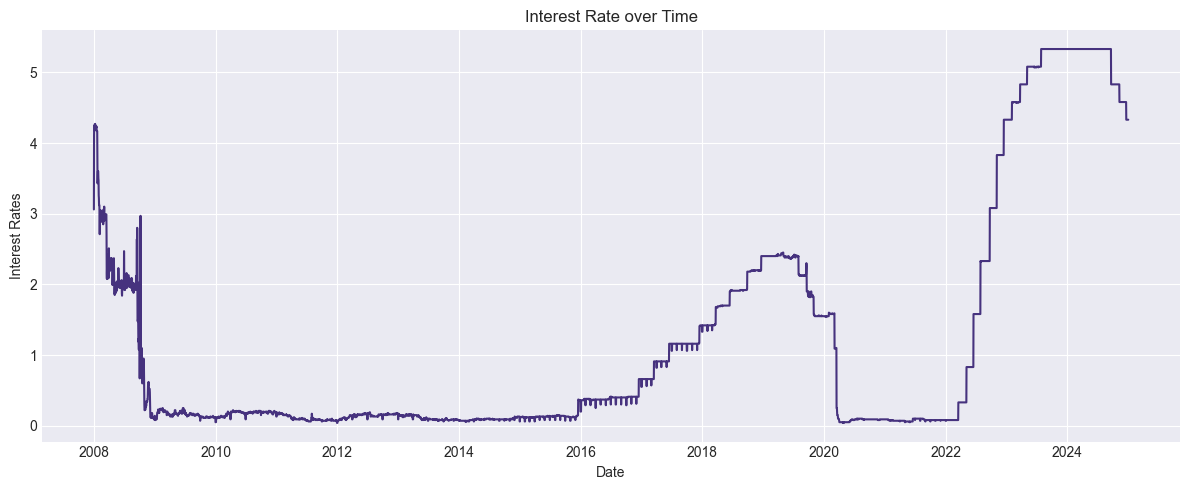

In [576]:
plt.figure(figsize=(12, 5))
plt.plot(us_interest_rate.index, us_interest_rate['US_Interest_Rate'])
plt.xlabel('Date')
plt.ylabel('Interest Rates')
plt.title('Interest Rate over Time')
plt.tight_layout()
plt.show()

In [471]:
us_interest_rate.to_csv('datasets/cleaned/us_interest_rate_daily.csv', index=True)

### Ghana GDP

In [479]:
gdp = pd.read_csv('datasets/gh/gdp.csv')
gdp.head()

,Name of Series,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,2009Q3,2009Q4,2010Q1,...,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4,2024Q1,2024Q2,2024Q3,2024Q4
0,"Gross Domestic Product (GDP), production, real",18863.43405,17762.604760,22941.78996,23134.54840,19210.10310,18421.36106,23667.45696,25411.41040,21005.42351,...,44155.5,48793.5,48419.4,42222.2,45003.2,51281.1,50620,44639.8,48159.1,53957.1
1,"Gross Domestic Product (GDP), production, nominal",10104.89685,9290.461975,13226.58088,13356.53098,11694.98317,12279.52857,14995.64126,16787.94786,16594.92305,...,153922.5,185636.5,221608.4,195700.7,216208.8,254230.2,284402,258924.5,293071.4,332477.5


In [480]:
# Drop the second row
gdp = gdp.drop(index=1).reset_index(drop=True)

# Set the first column as 'Name of Series', then drop it - we only want the quarterly columns as data
gdp = gdp.set_index('Name of Series')

# Limit columns to between 2006Q1 and 2023Q4 (inclusive)
quarters = [col for col in gdp.columns if (col >= '2008Q1' and col <= '2024Q4')]

# Prepare a DataFrame to store daily data
import pandas as pd

daily_gdp = []

for q in quarters:
    # Parse year and quarter
    year, qtr = q[:4], q[4:]
    # Determine quarter start and end month/day
    if qtr == 'Q1':
        start = f'{year}-01-01'
        end   = f'{year}-03-31'
    elif qtr == 'Q2':
        start = f'{year}-04-01'
        end   = f'{year}-06-30'
    elif qtr == 'Q3':
        start = f'{year}-07-01'
        end   = f'{year}-09-30'
    elif qtr == 'Q4':
        start = f'{year}-10-01'
        end   = f'{year}-12-31'
    else:
        continue  # skip columns that are not quarters
    # Generate date range for the quarter (calendar day)
    dates = pd.date_range(start=start, end=end, freq='D')
    for dt in dates:
        daily_gdp.append({'Date': dt, 'GDP': gdp[q].values[0]})

gdp_daily_df = pd.DataFrame(daily_gdp)

gdp_daily_df.head()

,Date,GDP
0,2008-01-01,18863.43405
1,2008-01-02,18863.43405
2,2008-01-03,18863.43405
3,2008-01-04,18863.43405
4,2008-01-05,18863.43405


In [481]:
gdp_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6210 entries, 0 to 6209
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6210 non-null   datetime64[ns]
 1   GDP     6210 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 97.2 KB


In [483]:
gdp_daily_df.tail()

,Date,GDP
6205,2024-12-27,53957.1
6206,2024-12-28,53957.1
6207,2024-12-29,53957.1
6208,2024-12-30,53957.1
6209,2024-12-31,53957.1


In [484]:
gdp_daily_df.rename(columns={'GDP': 'Gh_GDP'}, inplace=True)

In [487]:
gdp_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6210 entries, 0 to 6209
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6210 non-null   datetime64[ns]
 1   Gh_GDP  6210 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 97.2 KB


In [488]:
gdp_daily_df.to_csv('datasets/cleaned/gh_gdp_daily.csv', index=False)

### Interest Rates

In [489]:
interest_rates = pd.read_csv('datasets/gh/interest rates.csv')

In [490]:
interest_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Month                            216 non-null    object 
 1   Interbank weighted average rate  216 non-null    float64
 2   Monetary policy rate             216 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.2+ KB


In [491]:
interest_rates.head()

,Month,Interbank weighted average rate,Monetary policy rate
0,2023M12,30.2,30.0
1,2023M11,29.1,30.0
2,2023M10,28.5,30.0
3,2023M09,27.3,30.0
4,2023M08,26.6,30.0


In [492]:
# Convert the interest rates from monthly to daily values

if 'Month' in interest_rates.columns:
    # Parse 'Month' like '2023M12' as YYYY-MM
    try:
        # This format: '2023M12'
        interest_rates['Month_dt'] = pd.to_datetime(
            interest_rates['Month'].str.replace(r'M', '-', regex=True) + '-01',
            format='%Y-%m-%d',
            errors='coerce'
        )
    except Exception as e:
        print(f"Error parsing Month column: {e}")
        interest_rates['Month_dt'] = pd.NaT

    # Drop rows where parsing failed
    interest_rates = interest_rates.dropna(subset=['Month_dt'])

    # Set up a date range for all days in the period
    first_month = interest_rates['Month_dt'].min()
    last_month = interest_rates['Month_dt'].max()
    daily_index = pd.date_range(first_month, (last_month + pd.offsets.MonthEnd(0)), freq='D')

    # For each month, expand the row to all days in that month
    expanded_rows = []
    for _, row in interest_rates.iterrows():
        month_start = row['Month_dt']
        month_end = (month_start + pd.offsets.MonthEnd(0))
        month_days = pd.date_range(month_start, month_end, freq='D')
        data = {col: row[col] for col in interest_rates.columns if col != 'Month_dt'}
        for day in month_days:
            expanded_rows.append({'Date': day, **data})

    interest_rates_daily = pd.DataFrame(expanded_rows)

    # Optional: arrange columns order: Date first, then rest
    cols = ['Date'] + [col for col in interest_rates_daily.columns if col != 'Date']
    interest_rates_daily = interest_rates_daily[cols]

else:
    interest_rates_daily = None
    print("No 'Month' column found in interest_rates DataFrame.")

In [493]:
interest_rates_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             6574 non-null   datetime64[ns]
 1   Month                            6574 non-null   object        
 2   Interbank weighted average rate  6574 non-null   float64       
 3   Monetary policy rate             6574 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 205.6+ KB


In [494]:
interest_rates_daily.head()

,Date,Month,Interbank weighted average rate,Monetary policy rate
0,2023-12-01,2023M12,30.2,30.0
1,2023-12-02,2023M12,30.2,30.0
2,2023-12-03,2023M12,30.2,30.0
3,2023-12-04,2023M12,30.2,30.0
4,2023-12-05,2023M12,30.2,30.0


In [495]:
interest_rates_daily.drop(columns='Month', inplace=True)
interest_rates_daily.head()

,Date,Interbank weighted average rate,Monetary policy rate
0,2023-12-01,30.2,30.0
1,2023-12-02,30.2,30.0
2,2023-12-03,30.2,30.0
3,2023-12-04,30.2,30.0
4,2023-12-05,30.2,30.0


In [243]:
interest_rates_daily.to_csv('datasets/cleaned/gh_interest_rates_daily.csv')

### Commodity Prices

In [511]:
commodity_prices = pd.read_csv('datasets/gh/commodity prices.csv')

In [512]:
commodity_prices.head()

,Year,Variables,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2023,International Brent Crude Oil Price (US$/Barre...,84.9,80.21,79.2,81.15,75.61,74.24,81.79,85.28,93.05,88.28,81.85,76.08
1,2023,International Gold Price (US$/fine ounce) - Mo...,"1,816.43","1,857.11","1,949.43","1,935.24","1,849.50","1,837.07","1,737.13","1,763.71","1,682.12","1,666.68","1,726.39","1,796.21"
2,2023,International Cocoa Price (US$/Tonne) - Monthl...,"2,545.86","2,681.11","2,591.26","2,588.10","2,484.48","2,428.38","2,333.55","2,385.96","2,338.67","2,337.71","2,469.10","2,538.57"
3,2022,International Brent Crude Oil Price (US$/Barre...,85.48,94.28,112.51,105.81,111.55,117.22,105.14,97.74,90.57,93.6,90.38,81.34
4,2022,International Gold Price (US$/fine ounce) - Mo...,"1,816.43","1,857.11","1,949.43","1,935.24","1,849.50","1,837.07","1,737.13","1,763.71","1,682.12","1,666.68","1,726.39","1,796.21"


In [513]:
commodity_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       51 non-null     int64 
 1   Variables  51 non-null     object
 2   Jan        51 non-null     object
 3   Feb        51 non-null     object
 4   Mar        51 non-null     object
 5   Apr        51 non-null     object
 6   May        51 non-null     object
 7   Jun        51 non-null     object
 8   Jul        51 non-null     object
 9   Aug        51 non-null     object
 10  Sep        51 non-null     object
 11  Oct        51 non-null     object
 12  Nov        51 non-null     object
 13  Dec        51 non-null     object
dtypes: int64(1), object(13)
memory usage: 5.7+ KB


In [514]:
commodity_prices.head()

,Year,Variables,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2023,International Brent Crude Oil Price (US$/Barre...,84.9,80.21,79.2,81.15,75.61,74.24,81.79,85.28,93.05,88.28,81.85,76.08
1,2023,International Gold Price (US$/fine ounce) - Mo...,"1,816.43","1,857.11","1,949.43","1,935.24","1,849.50","1,837.07","1,737.13","1,763.71","1,682.12","1,666.68","1,726.39","1,796.21"
2,2023,International Cocoa Price (US$/Tonne) - Monthl...,"2,545.86","2,681.11","2,591.26","2,588.10","2,484.48","2,428.38","2,333.55","2,385.96","2,338.67","2,337.71","2,469.10","2,538.57"
3,2022,International Brent Crude Oil Price (US$/Barre...,85.48,94.28,112.51,105.81,111.55,117.22,105.14,97.74,90.57,93.6,90.38,81.34
4,2022,International Gold Price (US$/fine ounce) - Mo...,"1,816.43","1,857.11","1,949.43","1,935.24","1,849.50","1,837.07","1,737.13","1,763.71","1,682.12","1,666.68","1,726.39","1,796.21"


In [515]:
# Transform the commodity prices dataframe to wide format to allow proper time series analysis
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [516]:
def clean_numeric(value):
    if isinstance(value, str):
        return float(value.replace(',', ''))
    elif isinstance(value, (int, float)):
        return float(value)
    else:
        return np.nan


for col in months:
    commodity_prices[col] = commodity_prices[col].apply(clean_numeric)

In [517]:
# Below, we melt the dataframe to convert the months from columns to rows
data = commodity_prices.melt(
    id_vars=['Year', 'Variables'], value_vars=months, var_name='Month', value_name='Price')

# Pivot to create separate columns for each commodity
data_pivoted = data.pivot_table(
    index=['Year', 'Month'], columns='Variables', values='Price').reset_index()

data_pivoted.columns.name = None

# Rename the columns to make them more readable
data_pivoted = data_pivoted.rename(columns={
    'International Brent Crude Oil Price (US$/Barrel) - Monthly Average': 'Oil_Price',
    'International Cocoa Price (US$/Tonne) - Monthly Average': 'Cocoa_Price',
    'International Gold Price (US$/fine ounce) - Monthly Average': 'Gold_Price'
})

#  Convert Month names to numbers for easier time series analysis
months_number_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

data_pivoted['Month_Number'] = data_pivoted['Month'].map(months_number_mapping)

data_pivoted['Date'] = pd.to_datetime(
    data_pivoted['Year'].astype(str) + '-' +
    data_pivoted['Month_Number'].astype(str) + '-01'
)

commodity_prices = data_pivoted.sort_values('Date').reset_index(drop=True)

commodity_prices.head()

# Convert the 'Date' column to datetime format
# gh_commodity_data['Date'] = pd.to_datetime(gh_commodity_data['Date'])

,Year,Month,Oil_Price,Cocoa_Price,Gold_Price,Month_Number,Date
0,2007,Jan,54.56,1607.72,630.61,1,2007-01-01
1,2007,Feb,58.96,1711.95,664.42,2,2007-02-01
2,2007,Mar,62.36,1839.68,655.22,3,2007-03-01
3,2007,Apr,67.49,1897.38,678.84,4,2007-04-01
4,2007,May,67.92,1910.09,667.59,5,2007-05-01


In [518]:
commodity_prices = commodity_prices.drop(
    columns=['Year', 'Month', 'Month_Number'])

# gh_commodity_data.to_csv('datasets/gh/gh_commodity_data_cleaned.csv')
commodity_prices.head()

,Oil_Price,Cocoa_Price,Gold_Price,Date
0,54.56,1607.72,630.61,2007-01-01
1,58.96,1711.95,664.42,2007-02-01
2,62.36,1839.68,655.22,2007-03-01
3,67.49,1897.38,678.84,2007-04-01
4,67.92,1910.09,667.59,2007-05-01


In [519]:
def convert_monthly_to_daily(df, date_col="Date"):
    df = df.copy()
    # 1) ensure datetime and sort
    # df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # 2) for each monthly row, build the list of all days in that month
    #    (MonthEnd(0) jumps to the last day of the same month)
    daily = df.assign(
        **{
            date_col: df.apply(
                lambda r: pd.date_range(
                    start=r[date_col],
                    end=r[date_col] + pd.offsets.MonthEnd(0),
                    freq="D"
                ),
                axis=1
            )
        }
    ).explode(date_col, ignore_index=True)

    # 3) optional: set Date as index
    # daily = daily.set_index(date_col).sort_index()

    return daily

In [520]:
commodity_prices = convert_monthly_to_daily(commodity_prices, 'Date')

In [521]:
commodity_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6209 entries, 0 to 6208
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Oil_Price    6209 non-null   float64       
 1   Cocoa_Price  6209 non-null   float64       
 2   Gold_Price   6209 non-null   float64       
 3   Date         6209 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 194.2 KB


In [522]:
commodity_prices.head()

,Oil_Price,Cocoa_Price,Gold_Price,Date
0,54.56,1607.72,630.61,2007-01-01
1,54.56,1607.72,630.61,2007-01-02
2,54.56,1607.72,630.61,2007-01-03
3,54.56,1607.72,630.61,2007-01-04
4,54.56,1607.72,630.61,2007-01-05


In [523]:
commodity_prices.to_csv('datasets/cleaned/gh_commodity_prices_daily.csv')

### Inflation Data

In [257]:
inflation_rates = pd.read_csv('datasets/gh/inflation.csv')
inflation_rates.head()

,Name of Series,Jan-06,Feb-06,Mar-06,Apr-06,May-06,Jun-06,Jul-06,Aug-06,Sep-06,...,Mar-23,Apr-23,May-23,Jun-23,Jul-23,Aug-23,Sep-23,Oct-23,Nov-23,Dec-23
0,Food Inflation,11.69,10.73,10.66,10.55,11.43,10.67,11.84,10.77,8.73,...,50.8,48.7,51.79,54.23,55.01,51.86,49.34,44.77,32.21,28.68
1,Headline Inflation,12.76,12.27,11.28,11.21,11.75,11.39,12.91,12.56,11.67,...,45.0,41.2,42.20,42.50,43.09,40.07,38.08,35.21,26.41,23.19


In [258]:
# Pivot the inflation_rates dataframe so each "Name of Series" becomes a column,
# and the date columns become rows, with their values.
# The date columns are like 'Jan-06', 'Feb-06', etc.

# First, set "Name of Series" as index and transpose to get required format
inflation_df = inflation_rates.set_index('Name of Series').transpose()

# The index now contains the date headers like 'Jan-06', make this an explicit column
inflation_df = inflation_df.reset_index().rename(columns={'index': 'Date'})

inflation_df.head()

Name of Series,Date,Food Inflation,Headline Inflation
0,Jan-06,11.69,12.76
1,Feb-06,10.73,12.27
2,Mar-06,10.66,11.28
3,Apr-06,10.55,11.21
4,May-06,11.43,11.75


In [259]:
# Convert the monthly values in inflation_df to daily values, forward-filling for each day in the month.
# First, convert 'Date' like 'Jan-06' to period, then to start_of_month
inflation_df['Date'] = pd.to_datetime(inflation_df['Date'], format='%b-%y')

# Set the date column as the index
inflation_df = inflation_df.set_index('Date')

# Resample to daily frequency, forward-fill monthly value to all days in each month
inflation_df = inflation_df.resample('D').ffill()

inflation_df.head()

Name of Series,Food Inflation,Headline Inflation
Date,,
2006-01-01,11.69,12.76
2006-01-02,11.69,12.76
2006-01-03,11.69,12.76
2006-01-04,11.69,12.76
2006-01-05,11.69,12.76


In [260]:
inflation_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6544 entries, 2006-01-01 to 2023-12-01
Freq: D
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Food Inflation      6544 non-null   float64
 1   Headline Inflation  6544 non-null   float64
dtypes: float64(2)
memory usage: 153.4 KB


In [261]:
inflation_df.drop(columns='Food Inflation', inplace=True) # Drop Food Inflation as as the headline inflation has food and non-food as components

In [262]:
inflation_df.to_csv('datasets/cleaned/gh_inflation_rates_daily.csv')

In [540]:
# # Daily dataset has Interest Rate and Commodity Prices for GH
daily_dataset_df = pd.read_csv('datasets/cleaned/daily_dataset_2008.csv')
exchange_rates_df = pd.read_csv('datasets/cleaned/exchange rates.csv')
#gh specific
gh_gdp_df = pd.read_csv('datasets/cleaned/gh_gdp_daily.csv')
# gh_inflation_df = pd.read_csv('datasets/cleaned/gh_inflation_rates_daily.csv')

#us specific
us_gdp_df = pd.read_csv('datasets/cleaned/us_gdp_daily.csv')
us_inflation_df = pd.read_csv('datasets/cleaned/us_inflation_daily.csv')
us_interest_rate_df = pd.read_csv('datasets/cleaned/us_interest_rate_daily.csv')


In [544]:
# import pandas as pd
dss = [daily_dataset_df, exchange_rates_df, gh_gdp_df, us_gdp_df, us_inflation_df, us_interest_rate_df]
# loop through each dataframe and convert 'Date' to datetime
for df in dss:
    # Use format='mixed' and dayfirst=True to handle various date formats robustly
    df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True, errors='coerce')
    # df.dropna(subset=['Date'], inplace=True)  # Drop rows where 'Date' conversion failed
    # df.sort_values('Date', inplace=True)  # Sort by date
    # df.reset_index(drop=True, inplace=True)  # Reset index after sorting
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6210 entries, 0 to 6209
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               6210 non-null   datetime64[ns]
 1   MPR                6210 non-null   float64       
 2   FoodInflation      6210 non-null   float64       
 3   HeadlineInflation  6210 non-null   float64       
 4   NonFoodInflation   6210 non-null   float64       
 5   BrentOil           6210 non-null   float64       
 6   Cocoa              6210 non-null   float64       
 7   Gold               6210 non-null   float64       
 8   InterestRate       6210 non-null   float64       
 9   NetForeignAssets   6210 non-null   float64       
 10  NIR                6210 non-null   float64       
 11  Imports            6210 non-null   float64       
 12  Exports            6210 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 630.8 KB
<class

In [545]:
# # Merge all datasets on 'Date'
merged_df = exchange_rates_df.copy()
merged_df = pd.merge(merged_df, daily_dataset_df, on='Date', how='left')

merged_df = pd.merge(merged_df, gh_gdp_df, on='Date',   how='left')
# merged_df = pd.merge(merged_df, gh_inflation_df, on='Date', how='left')

merged_df = pd.merge(merged_df, us_gdp_df, on='Date', how='left')
merged_df = pd.merge(merged_df, us_inflation_df, on='Date', how='left')
merged_df = pd.merge(merged_df, us_interest_rate_df, on='Date', how='left')

In [266]:
# merged_df = exchange_rates_df.copy()
# merged_df = pd.merge(merged_df, daily_dataset_df, on='Date', how='left')

# merged_df = pd.merge(merged_df, gh_inflation_df, on='Date', how='left')
# merged_df = pd.merge(merged_df, gh_gdp_df, on='Date', how='left')

# merged_df = pd.merge(merged_df, us_inflation_df, on='Date', how='left')
# merged_df = pd.merge(merged_df, us_interest_rate_df, on='Date', how='left')
# merged_df = pd.merge(merged_df, us_gdp_df, on='Date', how='left')

# merged_df = pd.merge(merged_df, ghana_inflation_m, on='Date', how='left')
# merged_df = pd.merge(merged_df, us_inflation_m, on='Date', how='left')
# merged_df = pd.merge(merged_df, ghana_interest_rate_m, on='Date', how='left')
# merged_df = pd.merge(merged_df, us_interest_rate_m, on='Date', how='left')
# merged_df = pd.merge(merged_df, ghana_gdp_m, on='Date', how='left')
# merged_df = pd.merge(merged_df, us_gdp_m, on='Date', how='left')
# merged_df = pd.merge(merged_df, commodity_prices_m, on='Date', how='left')

In [546]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               4217 non-null   datetime64[ns]
 1   Buying             4217 non-null   float64       
 2   Selling            4217 non-null   object        
 3   Mid Rate           4217 non-null   object        
 4   MPR                4217 non-null   float64       
 5   FoodInflation      4217 non-null   float64       
 6   HeadlineInflation  4217 non-null   float64       
 7   NonFoodInflation   4217 non-null   float64       
 8   BrentOil           4217 non-null   float64       
 9   Cocoa              4217 non-null   float64       
 10  Gold               4217 non-null   float64       
 11  InterestRate       4217 non-null   float64       
 12  NetForeignAssets   4217 non-null   float64       
 13  NIR                4217 non-null   float64       
 14  Imports 

In [268]:
# merged_df.isnull().sum()

In [547]:
merged_df.to_csv('datasets/cleaned/merged_fx_dataset.csv', index=False)

In [366]:
# final_datasets = [
# exchange_rates,
# daily_dataset,
# daily_us_gdp_df,
# us_inflation_daily,
# us_interest_rate,
# gdp_daily_df,
# # interest_rates_daily,
# ]

# for i in final_datasets:
#     print(i.shape)

(4217, 4)
(7153, 10)
(5834, 2)
(5856, 1)
(6210, 1)
(5844, 2)


In [ ]:
# # Ensure 'Date' column in all dataframes is of datetime type
# for i, df in enumerate(final_datasets):
#     if 'Date' in df.columns:
#         final_datasets[i]['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [ ]:
# # merge all datasets on 'Date' in the final_datasets list
# merged_df = final_datasets[0]
# for df in final_datasets[1:]:
#     merged_df = pd.merge(merged_df, df, on='Date', how='left')
# merged_df.to_csv('datasets/cleaned/merged_fx_dataset.csv', index=False)

In [548]:
merged_df.head()

,Date,Buying,Selling,Mid Rate,MPR,FoodInflation,HeadlineInflation,NonFoodInflation,BrentOil,Cocoa,Gold,InterestRate,NetForeignAssets,NIR,Imports,Exports,Gh_GDP,US_GDP,US_Inflation_Rate,US_Interest_Rate
0,2024-12-31,14.6927,14.7074,14.7,27.0,27.77,23.82,20.32,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
1,2024-12-30,14.7026,14.7174,14.71,27.0,27.77,23.82,20.32,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
2,2024-12-27,14.6927,14.7074,14.7,27.0,27.77,23.82,20.32,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
3,2024-12-24,14.6427,14.6573,14.65,27.0,27.77,23.82,20.32,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
4,2024-12-23,14.6427,14.6573,14.65,27.0,27.77,23.82,20.32,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33


In [549]:
merged_df.columns

Index(['Date', 'Buying', 'Selling', 'Mid Rate', 'MPR', 'FoodInflation',
       'HeadlineInflation', 'NonFoodInflation', 'BrentOil', 'Cocoa', 'Gold',
       'InterestRate', 'NetForeignAssets', 'NIR', 'Imports', 'Exports',
       'Gh_GDP', 'US_GDP', 'US_Inflation_Rate', 'US_Interest_Rate'],
      dtype='object')

In [550]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               4217 non-null   datetime64[ns]
 1   Buying             4217 non-null   float64       
 2   Selling            4217 non-null   object        
 3   Mid Rate           4217 non-null   object        
 4   MPR                4217 non-null   float64       
 5   FoodInflation      4217 non-null   float64       
 6   HeadlineInflation  4217 non-null   float64       
 7   NonFoodInflation   4217 non-null   float64       
 8   BrentOil           4217 non-null   float64       
 9   Cocoa              4217 non-null   float64       
 10  Gold               4217 non-null   float64       
 11  InterestRate       4217 non-null   float64       
 12  NetForeignAssets   4217 non-null   float64       
 13  NIR                4217 non-null   float64       
 14  Imports 

In [ ]:
# cols = ['Date', 'Buying', 'Selling', 'Mid Rate', 'MPR', 'FoodInflation',
#         'HeadlineInflation', 'NonFoodInflation', 'USDGHS', 'BrentOil', 'Cocoa',
#         'Gold', 'InterestRate', 'NetForeignAssets', 'NIR', 'Imports', 'Exports',
#         'US_GDP', 'US_Inflation_Rate', 'US_Interest_Rate', 'GDP']

cols = ['Date', 'Buying', 'Selling', 'Mid Rate', 'MPR', 'HeadlineInflation',
        'BrentOil', 'Cocoa', 'Gold', 'InterestRate', 'US_GDP',
        'US_Inflation_Rate', 'US_Interest_Rate', 'Gh_GDP']

In [563]:
merged_df.rename(columns={
    'HeadlineInflation' : 'GhInflationRate',
    'Mid Rate': 'MidRate',
    'InterestRate': 'GhInterestRate',
    'US_GDP': 'USGDP',
    'US_Inflation_Rate': 'USInflationRate',
    'US_Interest_Rate': 'USInterestRate',
    'Gh_GDP': 'GhGDP'
}, inplace=True)

In [564]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              4217 non-null   datetime64[ns]
 1   Buying            4217 non-null   float64       
 2   Selling           4217 non-null   float64       
 3   MidRate           4217 non-null   float64       
 4   MPR               4217 non-null   float64       
 5   GhInflationRate   4217 non-null   float64       
 6   BrentOil          4217 non-null   float64       
 7   Cocoa             4217 non-null   float64       
 8   Gold              4217 non-null   float64       
 9   GhInterestRate    4217 non-null   float64       
 10  NetForeignAssets  4217 non-null   float64       
 11  NIR               4217 non-null   float64       
 12  Imports           4217 non-null   float64       
 13  Exports           4217 non-null   float64       
 14  GhGDP             4217 n

In [553]:
for col in ['Selling', 'MidRate']:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(
            merged_df[col], errors='coerce')

In [565]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              4217 non-null   datetime64[ns]
 1   Buying            4217 non-null   float64       
 2   Selling           4217 non-null   float64       
 3   MidRate           4217 non-null   float64       
 4   MPR               4217 non-null   float64       
 5   GhInflationRate   4217 non-null   float64       
 6   BrentOil          4217 non-null   float64       
 7   Cocoa             4217 non-null   float64       
 8   Gold              4217 non-null   float64       
 9   GhInterestRate    4217 non-null   float64       
 10  NetForeignAssets  4217 non-null   float64       
 11  NIR               4217 non-null   float64       
 12  Imports           4217 non-null   float64       
 13  Exports           4217 non-null   float64       
 14  GhGDP             4217 n

In [557]:
merged_df.fillna(method='ffill', inplace=True)

In [566]:
merged_df.isnull().sum()

Date                0
Buying              0
Selling             0
MidRate             0
MPR                 0
GhInflationRate     0
BrentOil            0
Cocoa               0
Gold                0
GhInterestRate      0
NetForeignAssets    0
NIR                 0
Imports             0
Exports             0
GhGDP               0
USGDP               0
USInflationRate     0
USInterestRate      0
dtype: int64

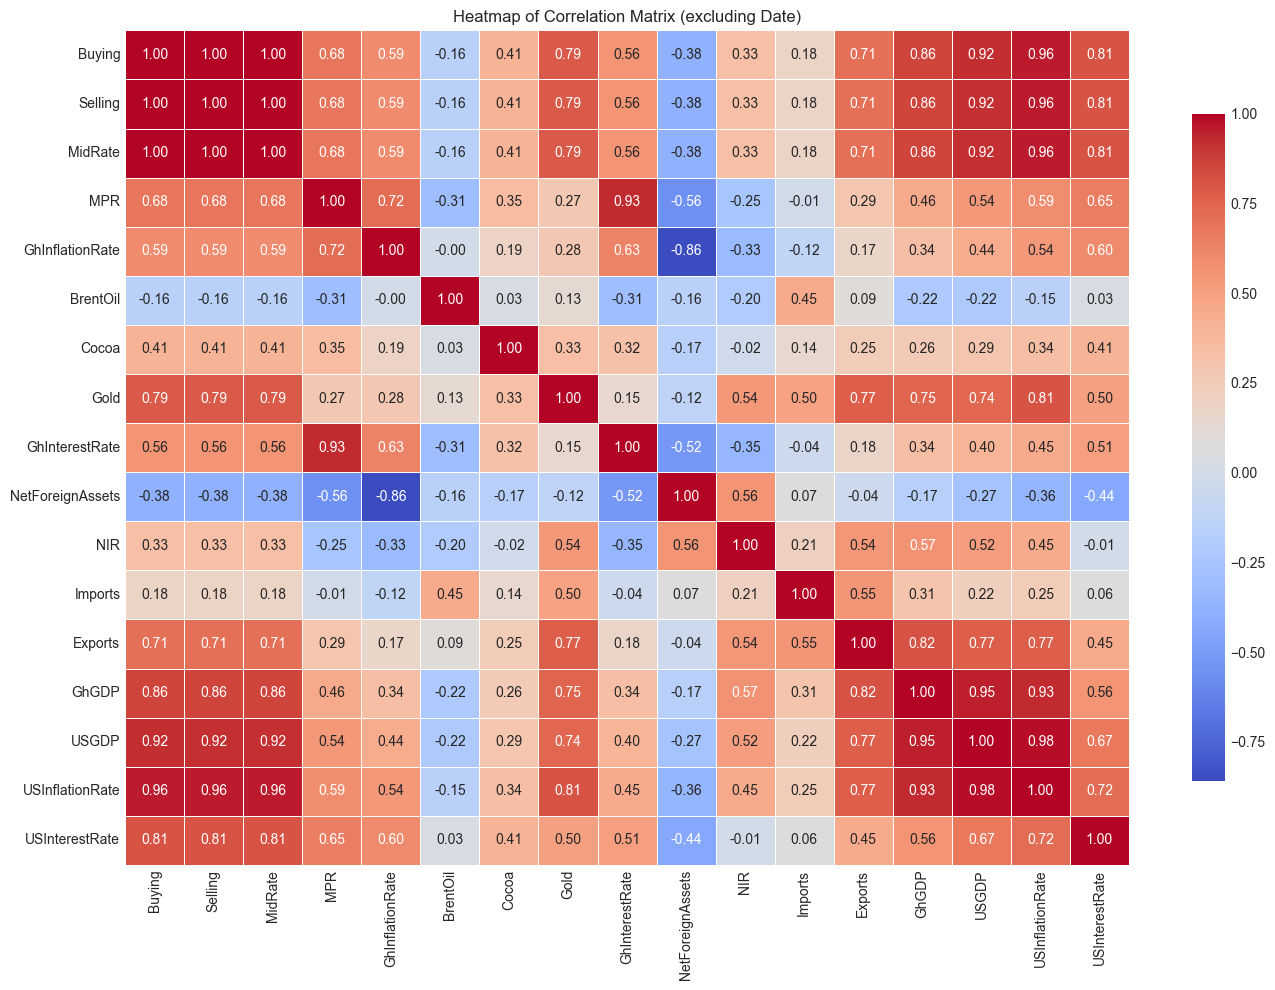

In [567]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select all columns except 'Date'
corr_df = merged_df.drop(columns=['Date'])

# Compute the correlation matrix
corr_matrix = corr_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
    linewidths=0.5, cbar_kws={"shrink": .8}
)
plt.title("Heatmap of Correlation Matrix (excluding Date)")
plt.tight_layout()
plt.show()


In [560]:
merged_df.drop(columns=['FoodInflation', 'NonFoodInflation'], inplace=True)

In [562]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               4217 non-null   datetime64[ns]
 1   Buying             4217 non-null   float64       
 2   Selling            4217 non-null   float64       
 3   MidRate            4217 non-null   float64       
 4   MPR                4217 non-null   float64       
 5   HeadlineInflation  4217 non-null   float64       
 6   BrentOil           4217 non-null   float64       
 7   Cocoa              4217 non-null   float64       
 8   Gold               4217 non-null   float64       
 9   GhInterestRate     4217 non-null   float64       
 10  NetForeignAssets   4217 non-null   float64       
 11  NIR                4217 non-null   float64       
 12  Imports            4217 non-null   float64       
 13  Exports            4217 non-null   float64       
 14  GhGDP   

In [568]:
merged_df.to_csv('datasets/cleaned/merged_fx_dataset.csv', index=False)